# Load Libraries, Modules, and Magics

In [376]:
import re
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import random
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
import xgboost as xgb
import operator
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
import scipy.stats as st
from scipy.stats.mstats import mode
from matplotlib import pyplot as plt
import seaborn as sns
import time
import math
import datetime
import random
from yellowbrick.features import ParallelCoordinates, Rank2D, JointPlotVisualizer
from yellowbrick.regressor import ResidualsPlot, AlphaSelection, PredictionError

%matplotlib inline

# Load the class to create a sparse scaler for log feature volumes

In [377]:
class SparseRobustMaxScaler(object):
    # for scaling log feature volume variables
    def __init__(self, percentile = 75):
        self.percentile_ = percentile

    def fit(self, X,y=None):
        z = np.copy(X)
        z[z==0] = np.NaN
        p = np.nanpercentile(np.abs(z),self.percentile_,axis=0)
        p[np.isnan(p)] = 1.
        self.scale_ = p

    def transform(self, X):
        return X / self.scale_

# Load (fixed) Data files

In [378]:
train_orig = pd.read_csv('./assets/train.csv', header=0)
test_orig = pd.read_csv('./assets/test.csv', header=0)
severity_type = pd.read_csv('./assets/severity_type.csv', header=0)
log_feature = pd.read_csv('./assets/log_feature.csv', header=0)
event_type = pd.read_csv('./assets/event_type.csv', header=0)
resource_type = pd.read_csv('./assets/resource_type.csv', header=0)

# Functions That Make EDA Easier

In [379]:
def str_to_num(string):
    return int(string.split(" ")[1])

In [380]:
def label_encoded_log_features(df, n):
    ind = df['volume'].values.argsort()
    if len(ind) > n:
        ind = ind[:n]
    lef = np.zeros(n,dtype=np.int32)
    lef[np.arange(len(ind))] = df['log_feature'].values[ind]
    return pd.Series(lef,np.arange(n)+1)

# EDA

In [381]:
pdp.ProfileReport(train_orig)

Number of variables,3
Number of observations,7381
Total Missing (%),0.0%
Total size in memory,173.1 KiB
Average record size in memory,24.0 B
Numeric,2
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [382]:
pdp.ProfileReport(test_orig)

Number of variables,2
Number of observations,11171
Total Missing (%),0.0%
Total size in memory,174.6 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [383]:
pdp.ProfileReport(severity_type)

Number of variables,2
Number of observations,18552
Total Missing (%),0.0%
Total size in memory,290.0 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [384]:
pdp.ProfileReport(log_feature)

Number of variables,3
Number of observations,58671
Total Missing (%),0.0%
Total size in memory,1.3 MiB
Average record size in memory,24.0 B
Numeric,2
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [385]:
pdp.ProfileReport(resource_type)

Number of variables,2
Number of observations,21076
Total Missing (%),0.0%
Total size in memory,329.4 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [386]:
pdp.ProfileReport(event_type)

Number of variables,2
Number of observations,31170
Total Missing (%),0.0%
Total size in memory,487.1 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Analysis:
The data files present multiple views into linked data tables. Based on cardinality, my educated guess is that the ID field  is the key between the tables, with location and log_feature containing relevant outage data. The objective is to predict Telstra network's fault severity at a particular location based on the log data. Each observation in the main dataset (train.csv, test.csv) represents a location and point in time. They are identified by the "id" column, which is the key "id" used in other data files. Fault severity has 3 categories: 0,1,2. The imbalance between classes makes modeling this function problematic. Therefore, I will split the 3 classes into separate functions for predictions, then join them back to create the submission table. The observation of “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv). Also, the observations have been pre-split into train and test sets, but let's verify that was done without bias.

# Feature Engineering

### 1. Join all tables (on ID) into one monolithic file to prepare for modeling
### 2. Verify that files were separated without bias
### 3. Create features where necessary, especially with low incidence observations
### 4. Use preprocessing column to record outcome of each row (NaNs, new features, etc.), and pivot to make clean break
### 5. Use mode of severity to indicate relative severity of element types

In [387]:
df1 = pd.concat([train_orig,test_orig], ignore_index=True, sort=False)
df1.head()

,id,location,fault_severity
0,14121,location 118,1.0
1,9320,location 91,0.0
2,14394,location 152,1.0
3,8218,location 931,1.0
4,14804,location 120,0.0


In [388]:
df1.shape

(18552, 3)

In [389]:
# Let's get a look at the breakdown of fault_severity, since this will be our target vector
df1.fault_severity.value_counts()

0.0    4784
1.0    1871
2.0     726
Name: fault_severity, dtype: int64

## Wow, that's a huge imbalance. The submission format requires predictions for each class, so we'll have to split them up.

## Before we go any further, let's make our first quick model, evaluate, predict, and score

In [390]:
# Assign train and test sets, then encode the target vector with OneHotEncoder so we have three categories.
train = train_orig
test = test_orig
num_train_data = train.shape[0]
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(train[['fault_severity']].as_matrix())

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [391]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [406]:
train.shape

(7381, 3)

In [392]:
y[:5]

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]])

In [393]:
# Now, prepare and combine the data sets, and get only the integers from 'location'
train_test = train.drop(['fault_severity'],axis=1)
train_test = train_test.append(test,ignore_index=True)
train_test['location'] = train_test.location.map(lambda x: re.findall(r'\d+',x)[0])

In [394]:
train_test.head()

,id,location
0,14121,118
1,9320,91
2,14394,152
3,8218,931
4,14804,120


In [395]:
# Next, join all the other data tables, on 'id', and get only the integers from the data columns
data = event_type.merge(resource_type, on = 'id', how = 'inner')
data = data.merge(severity_type, on = 'id', how = 'inner')
data = data.merge(log_feature, on = 'id', how = 'inner')
data['severity_type'] = data.severity_type.map(lambda x: re.findall(r'\d+',x)[0])
data['log_feature'] = data.log_feature.map(lambda x: re.findall(r'\d+',x)[0])
data['event_type'] = data.event_type.map(lambda x: re.findall(r'\d+',x)[0])
data['resource_type'] = data.resource_type.map(lambda x: re.findall(r'\d+',x)[0])

In [396]:
data.head()

,id,event_type,resource_type,severity_type,log_feature,volume
0,6597,11,8,2,68,6
1,8011,15,8,2,68,7
2,2597,15,8,2,68,1
3,5022,15,8,1,172,2
4,5022,15,8,1,56,1


In [397]:
data.shape

(146423, 6)

In [398]:
# Now let's create that monolithic dataframe
all_data = pd.merge(train_test, data, on='id', how='inner')
all_data.head(10)

,id,location,event_type,resource_type,severity_type,log_feature,volume
0,14121,118,34,2,2,312,19
1,14121,118,34,2,2,232,19
2,14121,118,35,2,2,312,19
3,14121,118,35,2,2,232,19
4,9320,91,34,2,2,315,200
5,9320,91,34,2,2,235,116
6,9320,91,35,2,2,315,200
7,9320,91,35,2,2,235,116
8,14394,152,35,2,2,221,1
9,14394,152,35,2,2,301,1


## Different types of features can be extracted from the log files and other sources. All above features are categorical except for "volume".

### Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). It should not be confused with fault_severity (our target variable). 


In [399]:
# Create the features dataframe, using the encoded monolithic categorical features, then add volume
feature_name = ['location', 'event_type', 'resource_type', 'severity_type', 'log_feature']
enc = OneHotEncoder(n_values=np.array([1127, 55, 11, 6, 387]), sparse=False)
features = all_data['id']
features = pd.concat([features, pd.DataFrame(data=enc.fit_transform(all_data[feature_name].as_matrix()))], axis=1)
features = features.astype(int)
features['vol'] = all_data['volume']
feature_name.append('volume')
features = features.groupby(['id'],sort=False, as_index=False).sum()
features.head() 

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


,id,0,1,2,3,4,5,6,7,8,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
0,14121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76
1,9320,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,632
2,14394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,8218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44
4,14804,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,96


In [401]:
features.shape

(18552, 1588)

### Wow, 1588 features. Let's see what we can do to focus on the low hanging fruit, and reduce overfitting. We'll use cross correlation to evaluate our top correlated features. 

In [402]:
# Create the Pearson cross correlation matrix
features_norm = (features - features.mean()) / (features.max() - features.min())
cross_corr = features_norm[:num_train_data].drop(['id'],axis=1)
cross_corr['y0'] = y[:,0]
cross_corr['y1'] = y[:,1]
cross_corr['y2'] = y[:,2]
cross_corr = cross_corr.corr().fillna(0)
cross_corr = cross_corr[['y0', 'y1', 'y2']].drop(['y0', 'y1', 'y2'])
cross_corr.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
y0,0.0,-0.013146,-0.023841,0.011507,-0.022345,0.008577,-0.015799,-0.004467,0.000210,0.036367,...,-0.017495,-1.762242e-15,-0.015799,-1.762242e-15,-1.762242e-15,-0.020538,0.008577,-1.762242e-15,-1.762242e-15,0.031061
y1,0.0,0.015727,0.031237,-0.009101,0.028252,-0.006783,0.019976,-0.015486,0.005416,-0.028763,...,-0.002030,-3.890519e-16,-0.006783,-3.890519e-16,-3.890519e-16,-0.008818,-0.006783,-3.890519e-16,-3.890519e-16,-0.102434
y2,0.0,-0.001892,-0.007398,-0.005159,-0.005438,-0.003845,-0.003845,0.029784,-0.008248,-0.016303,...,0.031020,-4.430143e-16,0.035243,-4.430143e-16,-4.430143e-16,0.045814,-0.003845,-4.430143e-16,-4.430143e-16,0.099820


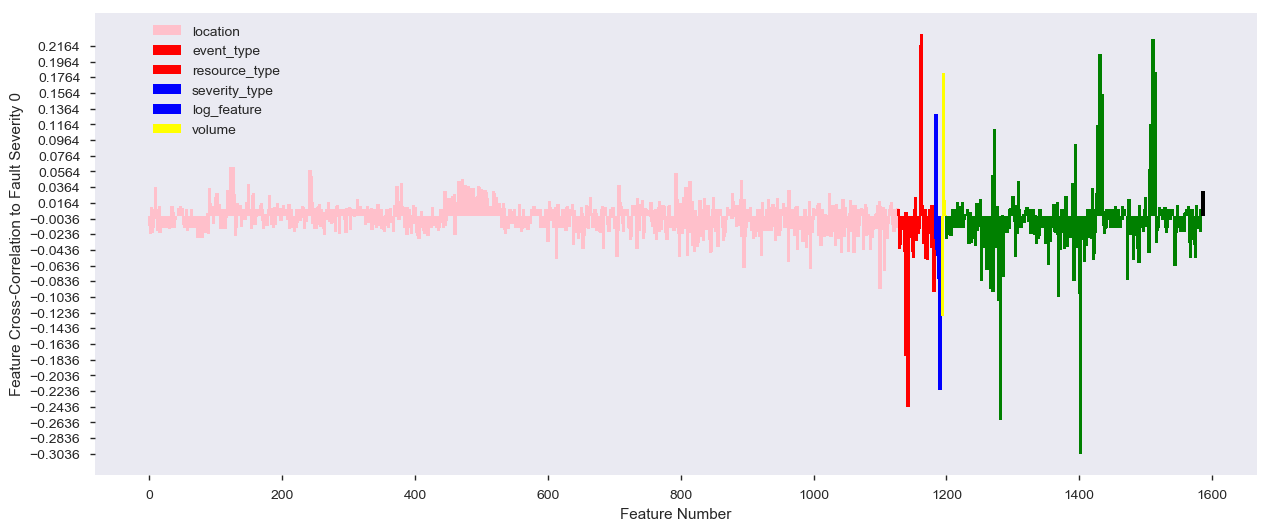

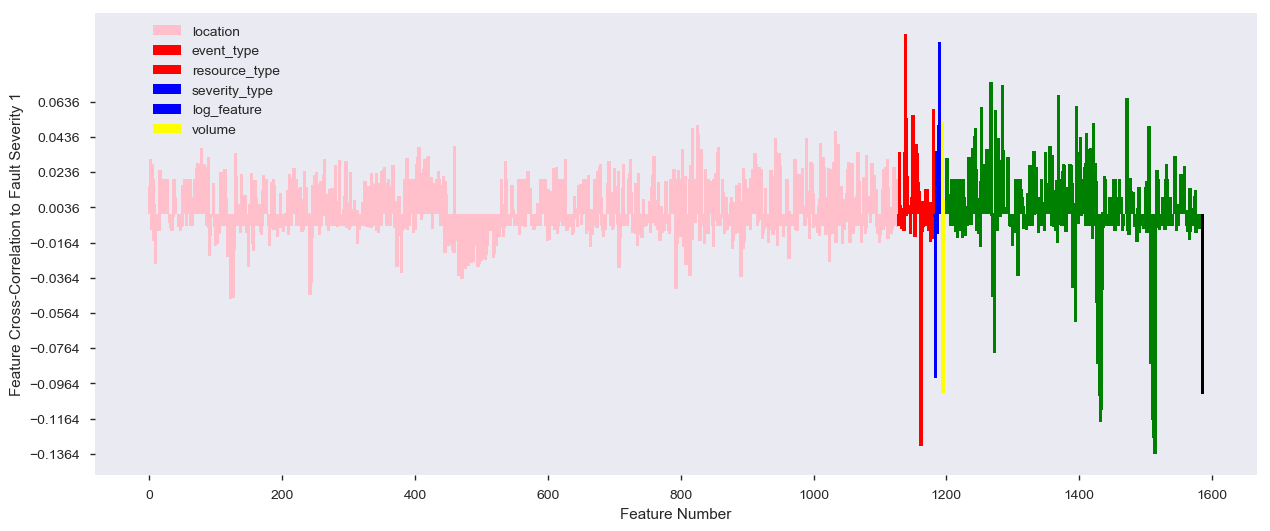

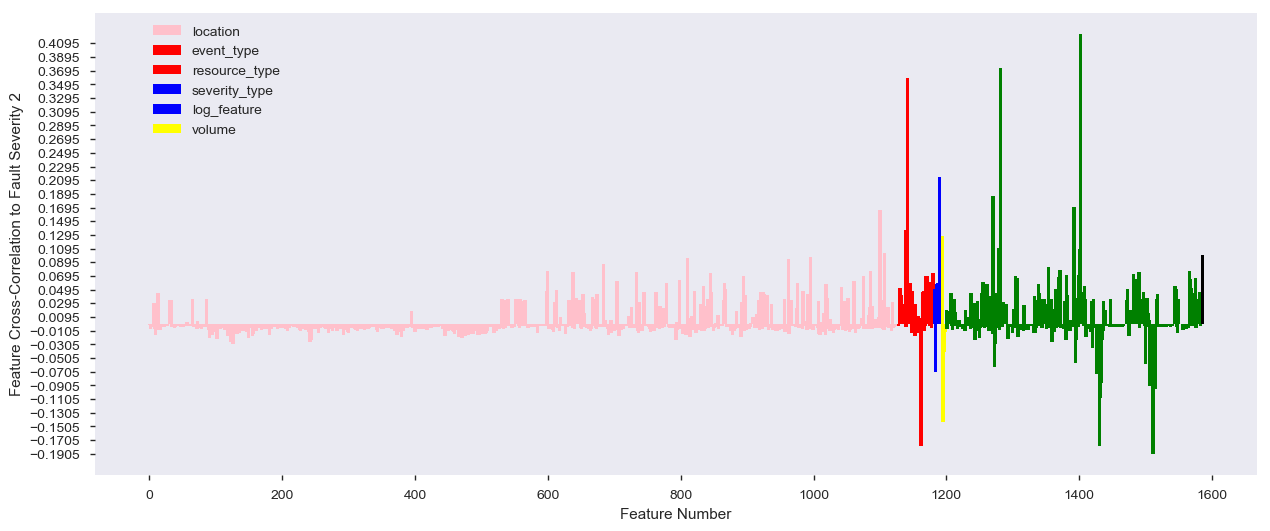

In [123]:
# now let's visualize that correlation matrix
clr = ['pink', 'red', 'blue', 'yellow', 'green', 'black']

for idx_corr in range(3):
    Y_corr = cross_corr.iloc[:,idx_corr]
    plt.figure(figsize=(15,6))
    for idx, n_featuer in enumerate(enc.n_values):
        xx = np.arange(enc.feature_indices_[idx], enc.feature_indices_[idx+1])
        yy = Y_corr[xx]
        plt.bar(xx, yy, width=5, color=clr[idx])
        plt.bar(1586,Y_corr[1586], width=5, color=clr[idx+1])
        plt.xlabel('Feature Number')
        plt.ylabel('Feature Cross-Correlation to Fault Severity '+str(idx_corr))
        plt.yticks(np.arange(min(yy), max(yy), 0.02))
        plt.grid(which='both', axis='both') 
        plt.legend(feature_name, bbox_to_anchor=(0.17, 1))    

In [124]:
# Choose a cross correlation threshold that will give us good signal without a lot of overfitting
cct = 0.05

In [125]:
# Finally! let's hit that XGB classifier syrup, with the buttery grid search, and thick cross validated goodness.
# We'll also need to run it for each target variable
for idx in range (3):
    X = features_norm[:num_train_data].drop(['id'],axis=1).values
    X = X[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    xgbc = xgb.XGBClassifier()
    clf1 = GridSearchCV(xgbc, {'max_depth': [5, 6, 7], 
                            'n_estimators': [100, 200, 300], 
                            'learning_rate': [0.05, 0.1, 0.15], 
                            'subsample': [1], 
                             }, 
                             verbose=1, n_jobs=3, cv=3, scoring='log_loss')
    clf1.fit(X, y[:,idx])
    print('best est', clf1.best_estimator_)
    print('best parms', clf1.best_params_)
    joblib.dump(clf1, '../dsi_capstone/clf1xgb'+str(idx)+'.pkl')   # pickle it if I need to flask it later, and predict


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:  6.3min finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.15, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:  6.2min finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:  6.3min finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


In [126]:
# Make predictions and score each target, then append to submission format

y_pred = []
log_loss = []
for idx in range(3):
    clf1 = joblib.load('../dsi_capstone/clf1xgb'+str(idx)+'.pkl') 
    X_t = features_norm[num_train_data:].drop(['id'],axis=1).as_matrix()
    X_t = X_t[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    y_pred.append(clf1.predict_proba(X_t))
    log_loss.append(-clf1.best_score_)
    print('Number of features for model ' + str(idx) + ' : ' + str(X_t.shape[1]))
    
print('Model log-loss: ' + str(np.mean(log_loss)))
    

prediction = pd.DataFrame({'id': features[num_train_data:].id,
                           'predict_0': y_pred[0][:,1], 
                           'predict_1': y_pred[1][:,1], 
                           'predict_2': y_pred[2][:,1]})

prediction.to_csv('../dsi_capstone/Telstra_clfxgb0b.csv',index=False)
prediction.head()

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Number of features for model 0 : 1581
Number of features for model 1 : 1581
Number of features for model 2 : 1581
Model log-loss: 0.345166167303


,id,predict_0,predict_1,predict_2
7381,11066,0.950125,0.026154,0.000770
7382,18000,0.280063,0.173259,0.716376
7383,16964,0.983213,0.024021,0.001261
7384,4795,0.718171,0.151227,0.010949
7385,3392,0.331073,0.297609,0.283577


In [127]:
1 - 572/974

0.4127310061601642

### Not too shabby, for the first try. Still overfitting like crazy.

### Now let's dig a little deeper into those log files and see what we can pull out. We're going to merge all the tables again, but this time we'll look more closely at location features, converting location and n_type strings to numbers.

In [159]:
# Read in all the data tables again, and convert location and n_type strings to numeric
train = pd.read_csv('./assets/train.csv', index_col='id', converters = {'location':str_to_num})
test = pd.read_csv('./assets/test.csv', index_col='id', converters = {'location':str_to_num})

events = pd.read_csv('./assets/event_type.csv', converters = {'event_type':str_to_num})
log = pd.read_csv('./assets/log_feature.csv', converters = {'log_feature':str_to_num})
resource = pd.read_csv('./assets/resource_type.csv', converters = {'resource_type':str_to_num})
sev = pd.read_csv('./assets/severity_type.csv', index_col = 'id',converters = {'severity_type':str_to_num})

In [160]:
# join train and test, this time we're going to append to keep the numerics lined up, and we've already keyed on the ID
df2 = train.append(test, sort=False)

In [172]:
df2.head()

,location,fault_severity
id,,
14121,118,1.0
9320,91,0.0
14394,152,1.0
8218,931,1.0
14804,120,0.0


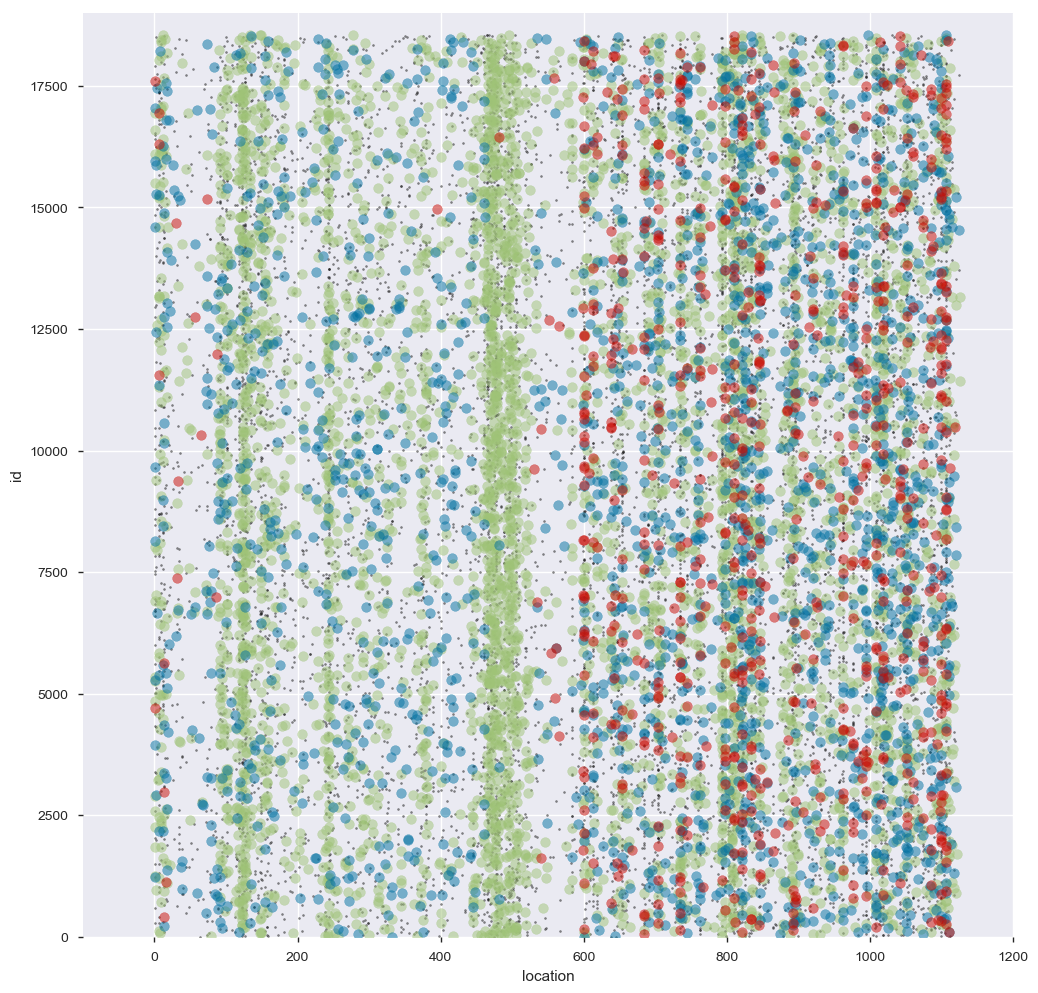

In [145]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(df2.loc[df2.fault_severity.isnull(),'location'],df2.loc[df2.fault_severity.isnull()].index,alpha=0.5,color='k',s=2)
ax.scatter(df2.loc[df2.fault_severity==0,'location'],df2.loc[df2.fault_severity==0].index,alpha=0.5,color='g')
ax.scatter(df2.loc[df2.fault_severity==1,'location'],df2.loc[df2.fault_severity==1].index,alpha=0.5,color='b')
ax.scatter(df2.loc[df2.fault_severity==2,'location'],df2.loc[df2.fault_severity==2].index,alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((0,19000))
ax.set_xlabel('location')
ax.set_ylabel('id');

### Analysis: location is definitely key to the problem, looks like < 500 is mostly green, while > 500 has a lot more red

In [162]:
# Now let's add fault_severity and location to the sev dataframe
sev['fault_severity'] = df2['fault_severity']
sev['location'] = df2['location']

In [163]:
sev.head()

,severity_type,fault_severity,location
id,,,
6597,2,NaN,1
8011,2,0.0,1
2597,2,NaN,1
5022,1,NaN,1
6852,1,NaN,1


In [164]:
sev.tail()

,severity_type,fault_severity,location
id,,,
3761,1,NaN,999
8720,1,NaN,999
6488,2,NaN,999
878,2,0.0,999
4464,1,0.0,999


### Looks like the rows are sorted by location, let's dig down that rabbit hole a little further. Be sure to bring an extra oxygen tank!

In [165]:
# record the count of each id at each location (and start at 1 instead of 0 so I can graph this)
sev['num'] = sev.groupby('location').cumcount() + 1
sev.head()

,severity_type,fault_severity,location,num
id,,,,
6597,2,NaN,1,1
8011,2,0.0,1,2
2597,2,NaN,1,3
5022,1,NaN,1,4
6852,1,NaN,1,5


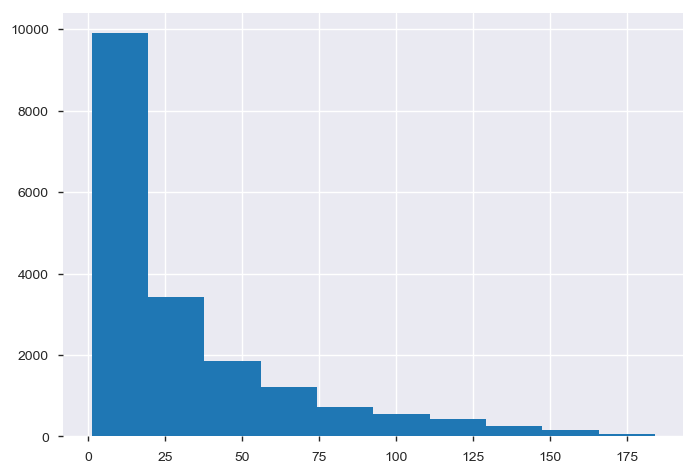

In [167]:
# let's visualize the frequency of location counts
sev['num'].hist()

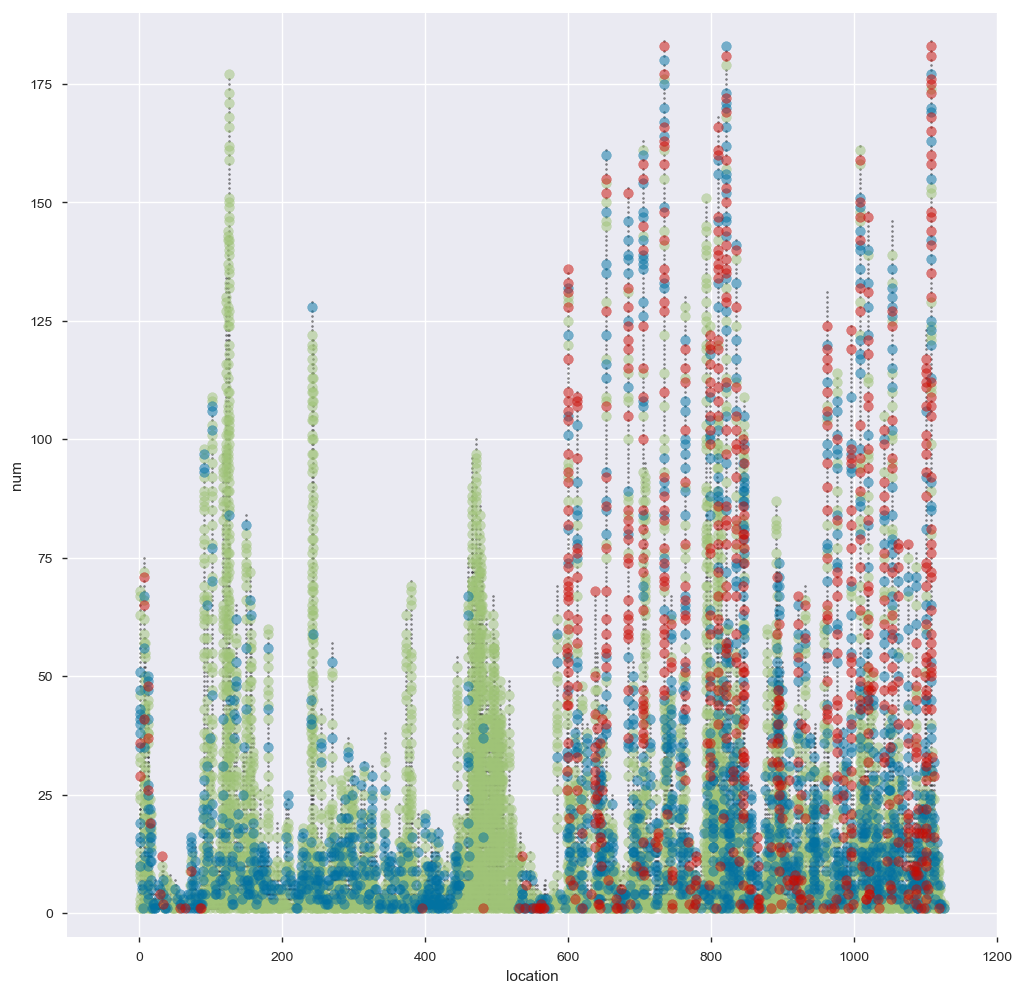

In [169]:
# now let's visualize that previous scatterplot again, this time we'll use the new count feature
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(sev.loc[sev.fault_severity.isnull(),'location'],sev.loc[sev.fault_severity.isnull(),'num'],alpha=0.5,color='k',s=2)
ax.scatter(sev.loc[sev.fault_severity==0,'location'],sev.loc[sev.fault_severity==0,'num'],alpha=0.5,color='g')
ax.scatter(sev.loc[sev.fault_severity==1,'location'],sev.loc[sev.fault_severity==1,'num'],alpha=0.5,color='b')
ax.scatter(sev.loc[sev.fault_severity==2,'location'],sev.loc[sev.fault_severity==2,'num'],alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((-5,190))
ax.set_xlabel('location')
ax.set_ylabel('num');

In [170]:
# definitely a pattern with our new feature, let's play around with the sorting to see if there's another angle here
# this is the reverse of the cumulative count we did above, but there doesn't appear to be a pandas way, so...
sev['revnum'] = sev.groupby('location')['num'].transform(lambda x: x.max() + 1 - x)
sev.head()

,severity_type,fault_severity,location,num,revnum
id,,,,,
6597,2,NaN,1,1,69
8011,2,0.0,1,2,68
2597,2,NaN,1,3,67
5022,1,NaN,1,4,66
6852,1,NaN,1,5,65


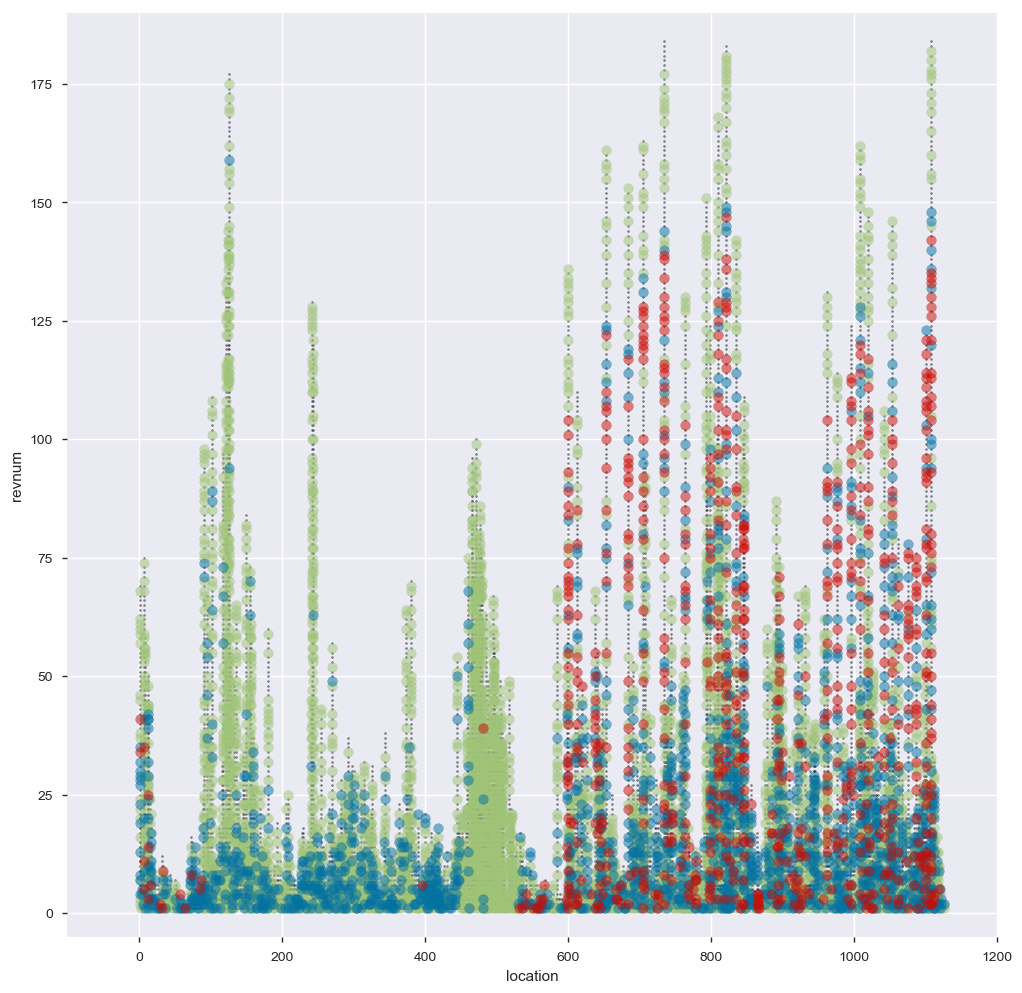

In [171]:
# and let's look at the new scatterplot
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(sev.loc[sev.fault_severity.isnull(),'location'],sev.loc[sev.fault_severity.isnull(),'revnum'],alpha=0.5,color='k',s=2)
ax.scatter(sev.loc[sev.fault_severity==0,'location'],sev.loc[sev.fault_severity==0,'revnum'],alpha=0.5,color='g')
ax.scatter(sev.loc[sev.fault_severity==1,'location'],sev.loc[sev.fault_severity==1,'revnum'],alpha=0.5,color='b')
ax.scatter(sev.loc[sev.fault_severity==2,'location'],sev.loc[sev.fault_severity==2,'revnum'],alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((-5,190))
ax.set_xlabel('location')
ax.set_ylabel('revnum');

In [265]:
features = []
features_to_scale = []
X = pd.DataFrame(0, index=sev.index, columns=[])

In [266]:
X['fault_severity'] = df2.fault_severity
X['sevtype'] = sev.severity_type
features.append('sevtype')
X['location'] = df2.location
features.append('location')
X['num'] = sev.num
features.append('num')
features_to_scale.append('num')

In [267]:
X.head()

,fault_severity,sevtype,location,num
id,,,,
6597,NaN,2,1,1
8011,0.0,2,1,2
2597,NaN,2,1,3
5022,NaN,1,1,4
6852,NaN,1,1,5


In [268]:
X.shape

(18552, 4)

In [269]:
# location counts
lc = pd.DataFrame(df2['location'].value_counts()).rename(columns={'location':'loc_count'})

In [270]:
lc.head()

,loc_count
1107,184
734,184
821,183
126,177
810,168


In [271]:
lc.shape

(1126, 1)

In [272]:
X = pd.merge(X, lc, how='left', left_on='location', right_index=True).fillna(0)

In [273]:
X.shape

(18552, 5)

In [274]:
X.head()

,fault_severity,sevtype,location,num,loc_count
id,,,,,
6597,0.0,2,1,1,69
8011,0.0,2,1,2,69
2597,0.0,2,1,3,69
5022,0.0,1,1,4,69
6852,0.0,1,1,5,69


In [275]:
features.append('loc_count')

In [276]:
features_to_scale.append('loc_count')

In [277]:
nevents = pd.DataFrame(events['id'].value_counts()).rename(columns={'id':'nevents'})

In [278]:
# number of events per id
nevents.shape

(18552, 1)

In [279]:
nevents.head()

,nevents
10354,11
15184,10
14243,10
17023,9
8590,9


In [280]:
X = pd.merge(X, nevents, right_index=True, left_index=True, how='left').fillna(0)

In [281]:
X.head()

,fault_severity,sevtype,location,num,loc_count,nevents
id,,,,,,
6597,0.0,2,1,1,69,1
8011,0.0,2,1,2,69,1
2597,0.0,2,1,3,69,1
5022,0.0,1,1,4,69,2
6852,0.0,1,1,5,69,2


In [282]:
X.shape

(18552, 6)

In [283]:
features.append('nevents')
features_to_scale.append('nevents')

In [284]:
# binary features for common events
evtypes = events.event_type.value_counts()

In [285]:
evtypes.head(20)

11    7888
35    6615
34    5927
15    4395
20    1458
54     684
13     582
42     478
44     466
23     429
14     330
43     306
22     223
50     154
10     145
21     136
18      73
47      69
26      65
32      63
Name: event_type, dtype: int64

In [286]:
common_events = evtypes.index

In [287]:
# top 20 events
common_events = common_events[:20]

In [288]:
# encode the top 20 events
ohevents = events.loc[events.event_type.isin(common_events)].groupby(['id','event_type'])['id'].count()

In [289]:
ohevents = ohevents.unstack().fillna(0).add_prefix('event')

In [290]:
ohevents.head()

event_type,event10,event11,event13,event14,event15,event18,event20,event21,event22,event23,event26,event32,event34,event35,event42,event43,event44,event47,event50,event54
id,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [291]:
X = pd.merge(X, ohevents, right_index=True, left_index=True, how='left').fillna(0)

In [292]:
X.head()

,fault_severity,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,...,event26,event32,event34,event35,event42,event43,event44,event47,event50,event54
id,,,,,,,,,,,,,,,,,,,,,
6597,0.0,2,1,1,69,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8011,0.0,2,1,2,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2597,0.0,2,1,3,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5022,0.0,1,1,4,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6852,0.0,1,1,5,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [293]:
features.extend(ohevents.columns)

In [294]:
# volume aggregates on log scale
log['logvolume'] = np.log(log.volume +1)

In [295]:
log.head()

,id,log_feature,volume,logvolume
0,6597,68,6,1.945910
1,8011,68,7,2.079442
2,2597,68,1,0.693147
3,5022,172,2,1.098612
4,5022,56,1,0.693147


In [296]:
X['volsumlog'] = np.log1p(log.groupby('id')['volume'].agg('sum'))

In [297]:
X.head()

,fault_severity,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,...,event32,event34,event35,event42,event43,event44,event47,event50,event54,volsumlog
id,,,,,,,,,,,,,,,,,,,,,
6597,0.0,2,1,1,69,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.945910
8011,0.0,2,1,2,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.079442
2597,0.0,2,1,3,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147
5022,0.0,1,1,4,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.397895
6852,0.0,1,1,5,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.791759


In [298]:
features.append('volsumlog')
features_to_scale.append('volsumlog')

In [299]:
logvol = log.groupby('id')['logvolume'].agg(['count','min','mean','max','std','sum']).fillna(0).add_prefix('logvolume_')

In [300]:
X = pd.merge(X, logvol, how='left', right_index=True, left_index=True).fillna(0)

In [301]:
features.extend(logvol.columns)
features_to_scale.extend(logvol.columns)

In [302]:
log.log_feature.value_counts()[:40]

312    5267
232    4754
82     3472
203    2823
313    2145
233    1901
307    1597
54     1573
170    1526
71     1514
315    1495
134    1419
80     1336
235    1294
193    1160
219    1152
68     1093
227    1080
314     950
201     902
234     882
73      868
195     783
301     707
309     627
55      564
229     560
273     491
308     484
368     462
376     460
171     459
228     438
283     420
306     412
291     401
310     399
230     367
70      364
345     321
Name: log_feature, dtype: int64

In [303]:
# Volume variables for common features
common_features = log.log_feature.value_counts().index

In [304]:
# top 40 common features
common_features = common_features[:40]

In [305]:
# encode common features
ohlog = log.loc[log.log_feature.isin(common_features)].groupby(['id','log_feature'])['logvolume'].mean()

In [306]:
ohlog = ohlog.unstack().fillna(0).add_prefix('logfeatvol_')

In [307]:
X = pd.merge(X, ohlog, how='left', left_index=True, right_index=True).fillna(0)

In [308]:
features.extend(ohlog.columns)
features_to_sparse_scale = list(ohlog.columns)

In [309]:
# Label-encoded features for max volume, min Volume
logfeatle = log.groupby('id').apply(label_encoded_log_features,4).add_prefix('logfeatle_')
X[logfeatle.columns] = logfeatle[logfeatle.columns]
features.extend(logfeatle.columns)

In [310]:
X.head()

,fault_severity,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,...,logfeatvol_313,logfeatvol_314,logfeatvol_315,logfeatvol_345,logfeatvol_368,logfeatvol_376,logfeatle_1,logfeatle_2,logfeatle_3,logfeatle_4
id,,,,,,,,,,,,,,,,,,,,,
6597,0.0,2,1,1,69,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,68,0,0,0
8011,0.0,2,1,2,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,68,0,0,0
2597,0.0,2,1,3,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,68,0,0,0
5022,0.0,1,1,4,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,56,172,71,193
6852,0.0,1,1,5,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,56,201,80,0


In [311]:
X['logfeatle_min'] = log.groupby('id').apply(lambda df:df['log_feature'].values[df['volume'].values.argmin()])
features.extend(['logfeatle_min'])

In [312]:
X.head()

,fault_severity,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,...,logfeatvol_314,logfeatvol_315,logfeatvol_345,logfeatvol_368,logfeatvol_376,logfeatle_1,logfeatle_2,logfeatle_3,logfeatle_4,logfeatle_min
id,,,,,,,,,,,,,,,,,,,,,
6597,0.0,2,1,1,69,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,68,0,0,0,68
8011,0.0,2,1,2,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,68,0,0,0,68
2597,0.0,2,1,3,69,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,68,0,0,0,68
5022,0.0,1,1,4,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56,172,71,193,56
6852,0.0,1,1,5,69,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56,201,80,0,56


In [313]:
# rmean = lambda x: pd.DataFrame.rolling(x,window=9,min_periods=1,center=True)
# X['logvolume_sum_ma9'] = X.groupby('location')['logvolume_sum'].transform(rmean)
# X['logvolume_sum_ma9_diff'] = X['logvolume_sum'] - X['logvolume_sum_ma9']
# X['volsumlog_ma9'] = X.groupby('location')['volsumlog'].transform(rmean)
# X['volsumlog_ma9_diff'] = X['volsumlog'] - X['volsumlog_ma9']
# ma = X.groupby('location')['logfeatvol_203'].transform(rmean)
# X['logfeatvol_203_ma9_diff'] = X['logfeatvol_203'] - ma
# features.extend(['logvolume_sum_ma9_diff','volsumlog_ma9_diff','logfeatvol_203_ma9_diff'])
# features_to_scale.extend(['logvolume_sum_ma9_diff','volsumlog_ma9_diff','logfeatvol_203_ma9_diff'])

In [314]:
nresources = pd.DataFrame(resource['id'].value_counts()).rename(columns={'id':'nresources'})
X = pd.merge(X, nresources, right_index=True, left_index=True, how='left').fillna(0)
features.append('nresources')
features_to_scale.append('nresources')

In [315]:
# encode common resources
restypes = resource.resource_type.value_counts()
common_resources = restypes.index
common_resources = common_resources[:5]
ohres = resource.loc[resource.resource_type.isin(common_resources)].groupby(['id','resource_type'])['resource_type'].count()
ohres = ohres.unstack().fillna(0.).add_prefix('restype_')
X = pd.merge(X, ohres, how='left', left_index=True, right_index=True).fillna(0.)
features.extend(ohres.columns)

### Now, ummmm, train, test, split, the old fashioned way, thanks to all the freakin feature engineering

In [321]:
Xtrain = X.loc[train.index, features]

In [322]:
Xtest = X.loc[test.index, features]

In [323]:
ytrain = X.loc[train.index, 'fault_severity']

In [360]:
ytraindf = pd.DataFrame(ytrain, columns=['fault_severity'])

In [363]:
ytraindf.head()

,fault_severity
id,
14121,1.0
9320,0.0
14394,1.0
8218,1.0
14804,0.0


In [324]:
ytest = X.loc[test.index, 'fault_severity']

In [325]:
Xtrain.head()

,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,event15,...,logfeatle_2,logfeatle_3,logfeatle_4,logfeatle_min,nresources,restype_2,restype_4,restype_6,restype_7,restype_8
id,,,,,,,,,,,,,,,,,,,,,
14121,2,118,31,97,2,0.0,0.0,0.0,0.0,0.0,...,232,0,0,312,1,1.0,0.0,0.0,0.0,0.0
9320,2,91,63,98,2,0.0,0.0,0.0,0.0,0.0,...,315,0,0,235,1,1.0,0.0,0.0,0.0,0.0
14394,2,152,4,12,2,0.0,0.0,0.0,0.0,0.0,...,301,0,0,221,1,1.0,0.0,0.0,0.0,0.0
8218,1,931,52,69,2,0.0,1.0,0.0,0.0,1.0,...,80,82,0,203,1,0.0,0.0,0.0,0.0,1.0
14804,1,120,19,19,4,0.0,1.0,0.0,0.0,0.0,...,219,117,181,134,2,1.0,0.0,0.0,0.0,1.0


In [326]:
Xtest.head()

,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,event15,...,logfeatle_2,logfeatle_3,logfeatle_4,logfeatle_min,nresources,restype_2,restype_4,restype_6,restype_7,restype_8
id,,,,,,,,,,,,,,,,,,,,,
11066,2,481,20,39,2,0.0,0.0,0.0,0.0,0.0,...,230,308,310,228,1,1.0,0.0,0.0,0.0,0.0
18000,1,962,32,131,2,0.0,1.0,0.0,0.0,1.0,...,82,0,0,203,1,0.0,0.0,0.0,0.0,1.0
16964,2,491,4,33,2,0.0,0.0,0.0,0.0,0.0,...,315,0,0,235,1,1.0,0.0,0.0,0.0,0.0
4795,5,532,8,17,2,1.0,0.0,0.0,0.0,0.0,...,38,37,0,240,2,0.0,0.0,0.0,0.0,0.0
3392,2,600,116,136,1,0.0,0.0,0.0,0.0,1.0,...,82,0,0,203,1,0.0,0.0,0.0,0.0,1.0


In [327]:
ytrain.head()

id
14121    1.0
9320     0.0
14394    1.0
8218     1.0
14804    0.0
Name: fault_severity, dtype: float64

In [328]:
ytest.head()

id
11066    0.0
18000    0.0
16964    0.0
4795     0.0
3392     0.0
Name: fault_severity, dtype: float64

In [318]:
# Scaling
scaler = StandardScaler()
scaler.fit(X[features_to_scale])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [329]:
Xtrain[features_to_scale] = scaler.transform(Xtrain[features_to_scale])

In [330]:
Xtest[features_to_scale] = scaler.transform(Xtest[features_to_scale])

In [332]:
sparse_scaler = SparseRobustMaxScaler()

In [334]:
sparse_scaler.fit(X[features_to_sparse_scale])

In [336]:
Xtrain[features_to_sparse_scale] = sparse_scaler.transform(Xtrain[features_to_sparse_scale])

In [338]:
Xtest[features_to_sparse_scale] = sparse_scaler.transform(Xtest[features_to_sparse_scale])

In [339]:
Xtrain.head()

,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,event15,...,logfeatle_2,logfeatle_3,logfeatle_4,logfeatle_min,nresources,restype_2,restype_4,restype_6,restype_7,restype_8
id,,,,,,,,,,,,,,,,,,,,,
14121,2,118,0.009627,0.707836,0.446232,0.0,0.0,0.0,0.0,0.0,...,232,0,0,312,-0.330139,1.0,0.0,0.0,0.0,0.0
9320,2,91,0.934275,0.727141,0.446232,0.0,0.0,0.0,0.0,0.0,...,315,0,0,235,-0.330139,1.0,0.0,0.0,0.0,0.0
14394,2,152,-0.770545,-0.933071,0.446232,0.0,0.0,0.0,0.0,0.0,...,301,0,0,221,-0.330139,1.0,0.0,0.0,0.0,0.0
8218,1,931,0.616428,0.167302,0.446232,0.0,1.0,0.0,0.0,1.0,...,80,82,0,203,-0.330139,0.0,0.0,0.0,0.0,1.0
14804,1,120,-0.337116,-0.797938,3.236425,0.0,1.0,0.0,0.0,0.0,...,219,117,181,134,2.096460,1.0,0.0,0.0,0.0,1.0


In [341]:
Xtrain.shape

(7381, 83)

In [340]:
Xtest.head()

,sevtype,location,num,loc_count,nevents,event10,event11,event13,event14,event15,...,logfeatle_2,logfeatle_3,logfeatle_4,logfeatle_min,nresources,restype_2,restype_4,restype_6,restype_7,restype_8
id,,,,,,,,,,,,,,,,,,,,,
11066,2,481,-0.308221,-0.411842,0.446232,0.0,0.0,0.0,0.0,0.0,...,230,308,310,228,-0.330139,1.0,0.0,0.0,0.0,0.0
18000,1,962,0.038522,1.364199,0.446232,0.0,1.0,0.0,0.0,1.0,...,82,0,0,203,-0.330139,0.0,0.0,0.0,0.0,1.0
16964,2,491,-0.770545,-0.527671,0.446232,0.0,0.0,0.0,0.0,0.0,...,315,0,0,235,-0.330139,1.0,0.0,0.0,0.0,0.0
4795,5,532,-0.654964,-0.836547,0.446232,1.0,0.0,0.0,0.0,0.0,...,38,37,0,240,2.096460,0.0,0.0,0.0,0.0,0.0
3392,2,600,2.465724,1.460723,-0.948864,0.0,0.0,0.0,0.0,1.0,...,82,0,0,203,-0.330139,0.0,0.0,0.0,0.0,1.0


In [342]:
Xtest.shape

(11171, 83)

In [348]:
ytrain.shape

(7381,)

In [349]:
ytest.shape

(11171,)

In [347]:
ytrain[:1]

id
14121    1.0
Name: fault_severity, dtype: float64

In [351]:
train.shape

(7381, 2)

In [352]:
train.head()

,location,fault_severity
id,,
14121,118,1
9320,91,0
14394,152,1
8218,931,1
14804,120,0


In [369]:
# Encode ytrain
enc = OneHotEncoder(sparse=False)
ytrain = enc.fit_transform(train[['fault_severity']].values)

In [374]:
ytrain

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [414]:
# Finally (again)! let's hit that XGB classifier syrup, with the buttery grid search, and thick cross validated goodness.
# We'll also need to run it for each target variable

for idx in range (3):
    xgbc = xgb.XGBClassifier()
    clf2 = GridSearchCV(xgbc, {'max_depth': [5, 6, 7], 
                            'n_estimators': [100, 200, 300], 
                            'learning_rate': [0.05, 0.1, 0.15], 
                            'subsample': [1], 
                             }, 
                             verbose=1, n_jobs=3, cv=3, scoring='log_loss')
    clf2.fit(Xtrain, ytrain[:,idx])
    print('best est', clf2.best_estimator_)
    print('best parms', clf2.best_params_)
    joblib.dump(clf2, '../dsi_capstone/clf2xgb'+str(idx)+'.pkl')   # pickle it if I need to flask it later, and predict

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   21.1s
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:   37.4s finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1}
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.4s
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:   36.4s finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1}
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.0s
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:   35.5s finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


In [429]:
y_pred = []
log_loss = []
for idx in range(3):
    clf2 = joblib.load('../dsi_capstone/clf2xgb'+str(idx)+'.pkl') 
    y_pred.append(clf2.predict_proba(Xtest))
    log_loss.append(-clf2.best_score_)
    print('Number of features for model ' + str(idx) + ' : ' + str(Xtest.shape[1]))
    
print('Model log-loss: ' + str(np.mean(log_loss)))
    

prediction = pd.DataFrame({'id': test.id,
                           'predict_0': y_pred[0][:,1], 
                           'predict_1': y_pred[1][:,1], 
                           'predict_2': y_pred[2][:,1]})

prediction.to_csv('../dsi_capstone/Telstra_clf2xgb0.csv',index=False)
prediction.head()

Number of features for model 0 : 83
Number of features for model 1 : 83
Number of features for model 2 : 83
Model log-loss: 0.291117886791


,id,predict_0,predict_1,predict_2
0,11066,0.978592,0.015390,0.000799
1,18000,0.063122,0.074521,0.541080
2,16964,0.996192,0.005422,0.000576
3,4795,0.513700,0.528943,0.001537
4,3392,0.287524,0.812092,0.014574


In [430]:
1 - 78/974

0.919917864476386

### That's more like it, made it into the top 10%, way better than my goal of breaking 50%